In [6]:
import numpy as np
from k_means import KMeans
from rv import RandomVariable
import matplotlib.pyplot as plt

In [7]:

class MultivariateGaussianMixture(RandomVariable):
    """
    p(x|mu, L, pi(coef))
    = sum_k pi_k N(x|mu_k, L_k^-1)
    """

    def __init__(self,
                 n_components,
                 mu=None,
                 cov=None,
                 tau=None,
                 coef=None):
        """
        construct mixture of Gaussians

        Parameters
        ----------
        n_components : int
            number of gaussian component
        mu : (n_components, ndim) np.ndarray
            mean parameter of each gaussian component
        cov : (n_components, ndim, ndim) np.ndarray
            variance parameter of each gaussian component
        tau : (n_components, ndim, ndim) np.ndarray
            precision parameter of each gaussian component
        coef : (n_components,) np.ndarray
            mixing coefficients
        """
        super().__init__()
        assert isinstance(n_components, int)
        self.n_components = n_components
        self.mu = mu
        if cov is not None and tau is not None:
            raise ValueError("Cannot assign both cov and tau at a time")
        elif cov is not None:
            self.cov = cov
        elif tau is not None:
            self.tau = tau
        else:
            self.cov = None
            self.tau = None
        self.coef = coef

    @property
    def mu(self):
        return self.parameter["mu"]

    @mu.setter
    def mu(self, mu):
        if isinstance(mu, np.ndarray):
            assert mu.ndim == 2
            assert np.size(mu, 0) == self.n_components
            self.ndim = np.size(mu, 1)
            self.parameter["mu"] = mu
        elif mu is None:
            self.parameter["mu"] = None
        else:
            raise TypeError("mu must be either np.ndarray or None")

    @property
    def cov(self):
        return self.parameter["cov"]

    @cov.setter
    def cov(self, cov):
        if isinstance(cov, np.ndarray):
            assert cov.shape == (self.n_components, self.ndim, self.ndim)
            self._tau = np.linalg.inv(cov)
            self.parameter["cov"] = cov
        elif cov is None:
            self.parameter["cov"] = None
            self._tau = None
        else:
            raise TypeError("cov must be either np.ndarray or None")

    @property
    def tau(self):
        return self._tau

    @tau.setter
    def tau(self, tau):
        if isinstance(tau, np.ndarray):
            assert tau.shape == (self.n_components, self.ndim, self.ndim)
            self.parameter["cov"] = np.linalg.inv(tau)
            self._tau = tau
        elif tau is None:
            self.parameter["cov"] = None
            self._tau = None
        else:
            raise TypeError("tau must be either np.ndarray or None")

    @property
    def coef(self):
        return self.parameter["coef"]

    @coef.setter
    def coef(self, coef):
        if isinstance(coef, np.ndarray):
            assert coef.ndim == 1
            if np.isnan(coef).any():
                self.parameter["coef"] = np.ones(self.n_components) / self.n_components
            elif not np.allclose(coef.sum(), 1):
                raise ValueError(f"sum of coef must be equal to 1 {coef}")
            self.parameter["coef"] = coef
        elif coef is None:
            self.parameter["coef"] = None
        else:
            raise TypeError("coef must be either np.ndarray or None")

    @property
    def shape(self):
        if hasattr(self.mu, "shape"):
            return self.mu.shape[1:]
        else:
            return None

    def _gauss(self, X):
        d = X[:, None, :] - self.mu
        D_sq = np.sum(np.einsum('nki,kij->nkj', d, self.cov) * d, -1)
        return (
            np.exp(-0.5 * D_sq)
            / np.sqrt(
                np.linalg.det(self.cov) * (2 * np.pi) ** self.ndim
            )
        )

    def _fit(self, X):
        cov = np.cov(X.T)
        kmeans = KMeans(self.n_components)
        kmeans.fit(X)
        self.mu = kmeans.centers
        self.cov = np.array([cov for _ in range(self.n_components)])
        self.coef = np.ones(self.n_components) / self.n_components
        params = np.hstack(
            (self.mu.ravel(),
             self.cov.ravel(),
             self.coef.ravel())
        )
        while True:
            stats = self._expectation(X)
            self._maximization(X, stats)
            new_params = np.hstack(
                (self.mu.ravel(),
                 self.cov.ravel(),
                 self.coef.ravel())
            )
            if np.allclose(params, new_params):
                break
            else:
                params = new_params

    def _expectation(self, X):
        resps = self.coef * self._gauss(X)
        resps /= resps.sum(axis=-1, keepdims=True)
        return resps

    def _maximization(self, X, resps):
        Nk = np.sum(resps, axis=0)
        self.coef = Nk / len(X)
        self.mu = (X.T @ resps / Nk).T
        d = X[:, None, :] - self.mu
        self.cov = np.einsum(
            'nki,nkj->kij', d, d * resps[:, :, None]) / Nk[:, None, None]

    def joint_proba(self, X):
        """
        calculate joint probability p(X, Z)

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input data

        Returns
        -------
        joint_prob : (sample_size, n_components) ndarray
            joint probability of input and component
        """
        return self.coef * self._gauss(X)

    def _pdf(self, X):
        joint_prob = self.coef * self._gauss(X)
        return np.sum(joint_prob, axis=-1)

    def classify(self, X):
        """
        classify input
        max_z p(z|x, theta)

        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input

        Returns
        -------
        output : (sample_size,) ndarray
            corresponding cluster index
        """
        return np.argmax(self.classify_proba(X), axis=1)

    def classify_proba(self, X):
        """
        posterior probability of cluster
        p(z|x,theta)

        Parameters
        ----------
        X : (sample_size, ndim) ndarray
            input

        Returns
        -------
        output : (sample_size, n_components) ndarray
            posterior probability of cluster
        """
        return self._expectation(X)

In [8]:
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

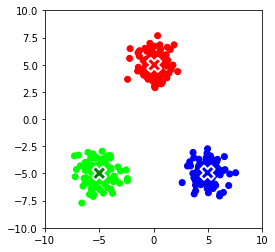

In [9]:
gmm = MultivariateGaussianMixture(n_components=3)
gmm.fit(x_train)
p = gmm.classify_proba(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=p)
plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()

In [10]:
# training data
x1 = np.random.normal(size=(100, 2))
x1 += np.array([-5, -5])
x2 = np.random.normal(size=(100, 2))
x2 += np.array([5, -5])
x3 = np.random.normal(size=(100, 2))
x3 += np.array([0, 5])
x_train = np.vstack((x1, x2, x3))

x0, x1 = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
x = np.array([x0, x1]).reshape(2, -1).T

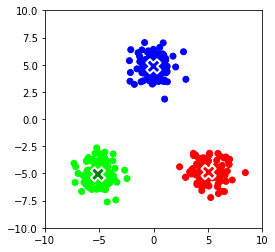

In [11]:
gmm = MultivariateGaussianMixture(n_components=3)
gmm.fit(x_train)
p = gmm.classify_proba(x_train)

plt.scatter(x_train[:, 0], x_train[:, 1], c=p)
plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], s=200, marker='X', lw=2, c=['red', 'green', 'blue'], edgecolor="white")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect("equal")
plt.show()